 # Problem Statement: 
 
 ABC bank aims to develop a robust predictive model to estimate loan amount for each loan applicant while minimizing the risk of default. The bank seeks to leverage historical loan data, applicant information, credit history to train models that is capable to predict the loan amount that balances the applicant's financial needs while maintaining bank's risk tolerance.


### Importing Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

## 1.0 Data Collection

- Dataset is 30000 rows , 24 variables
- Target data is Loan Sanction Amount (USD) 
- Continous data - Age, Income (USD), Loan Amount Request (USD), Current Loan Expenses (USD), Credit Score, Property Price, Property Age, Loan Sanction Amount (USD)
- Categorical data - Gender, Income Stability, Profession, Location, Expense Type 1, Expense Type 2, Dependents, No. of Defaults, Has Active Credit Card, Property Type, Property Location, Co-Applicant
- Unique Identifiers - Customer ID, Name, Property ID, Type of Employment
- After dropping unique identifiers, dataset size is 30000 rows, 20 variables

In [2]:
# loading  data 
data = pd.read_csv('train.csv')

# copy data 
df1 = data.copy()
df1.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [3]:
# describe data 
df1.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,30000.000000,2.542400e+04,30000.000000,29828.000000,27507.000000,28297.000000,30000.000000,30000.000000,2.515000e+04,30000.000000,30000.000000,3.000000e+04,29660.000000
mean,40.092300,2.630574e+03,88826.333855,400.936876,2.253027,739.885381,0.193933,501.934700,2.631119e+03,2.460067,-4.743867,1.317597e+05,47649.342208
std,16.045129,1.126272e+04,59536.949605,242.545375,0.951162,72.163846,0.395384,288.158086,1.132268e+04,1.118562,74.614593,9.354955e+04,48221.146686
min,18.000000,3.777000e+02,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,3.777000e+02,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1.650457e+03,41177.755000,247.667500,2.000000,681.880000,0.000000,251.000000,1.650450e+03,1.000000,1.000000,6.057216e+04,0.000000
50%,40.000000,2.222435e+03,75128.075000,375.205000,2.000000,739.820000,0.000000,504.000000,2.223250e+03,2.000000,1.000000,1.099936e+05,35209.395000
75%,55.000000,3.090593e+03,119964.605000,521.292500,3.000000,799.120000,0.000000,751.000000,3.091408e+03,3.000000,1.000000,1.788807e+05,74261.250000
max,65.000000,1.777460e+06,621497.820000,3840.880000,14.000000,896.260000,1.000000,999.000000,1.777460e+06,4.000000,1.000000,1.077967e+06,481907.320000


In [ ]:
# check data type
df1.info()

In [ ]:
data.shape

In [3]:
# Drop unique identifiers
unique_identifiers = ['Customer ID', 'Name', 'Type of Employment', 'Property ID']
df1 = data.drop(columns=unique_identifiers)
df1.shape

(30000, 20)

## 2.0 Data Exploration

- Check for missing values.
- Since the Loan Sanction Amount is target variable, and 0.01% missing value is insignificant the decision is to drop the missing values. 
- Dataset (df2) size is 29660, 20 
- Perform univariate analysis for continous and categorical variable. 
- Perform bivariate analysis using pearson correlation and boxplot analysis. 

### Check for missing values

In [4]:
# calculating percentage of missing values 
missing_percentage = {}

for i in df1.columns:
    missing_values = df1[i].isnull().sum()
    percentage = missing_values/len(df1)
    missing_percentage[i] = percentage

for i, percentage in missing_percentage.items():
    print(f'Column {i} has {percentage:.2f}% missing values.')

Column Gender has 0.00% missing values.
Column Age has 0.00% missing values.
Column Income (USD) has 0.15% missing values.
Column Income Stability has 0.06% missing values.
Column Profession has 0.00% missing values.
Column Location has 0.00% missing values.
Column Loan Amount Request (USD) has 0.00% missing values.
Column Current Loan Expenses (USD) has 0.01% missing values.
Column Expense Type 1 has 0.00% missing values.
Column Expense Type 2 has 0.00% missing values.
Column Dependents has 0.08% missing values.
Column Credit Score has 0.06% missing values.
Column No. of Defaults has 0.00% missing values.
Column Has Active Credit Card has 0.05% missing values.
Column Property Age has 0.16% missing values.
Column Property Type has 0.00% missing values.
Column Property Location has 0.01% missing values.
Column Co-Applicant has 0.00% missing values.
Column Property Price has 0.00% missing values.
Column Loan Sanction Amount (USD) has 0.01% missing values.


In [4]:
# drop missing value in target.
df2 = df1.dropna(subset=['Loan Sanction Amount (USD)'])
df2.shape

(29660, 20)

In [6]:
# continous vars and categorical vars
continous_vars = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Price', 'Property Age', 'Loan Sanction Amount (USD)']
categorical_vars = ['Gender', 'Income Stability', 'Profession', 'Location', 'Expense Type 1', 'Expense Type 2', 'Dependents', 'No. of Defaults', 'Has Active Credit Card', 'Property Type', 'Property Location', 'Co-Applicant']

### Univariate Analysis - Continous Variable

count    29660.000000
mean        40.099225
std         16.050024
min         18.000000
25%         25.000000
50%         40.000000
75%         55.000000
max         65.000000
Name: Age, dtype: float64


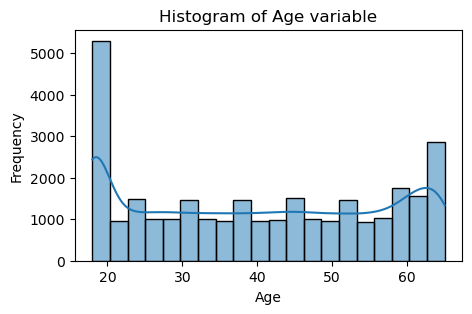

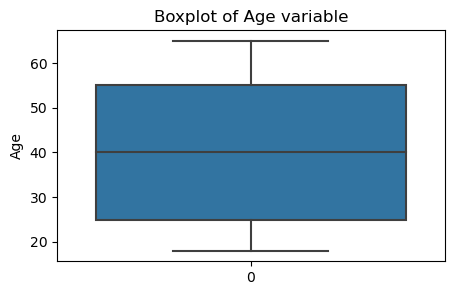

count    2.516700e+04
mean     2.630991e+03
std      1.131902e+04
min      3.777000e+02
25%      1.650250e+03
50%      2.223300e+03
75%      3.090330e+03
max      1.777460e+06
Name: Income (USD), dtype: float64


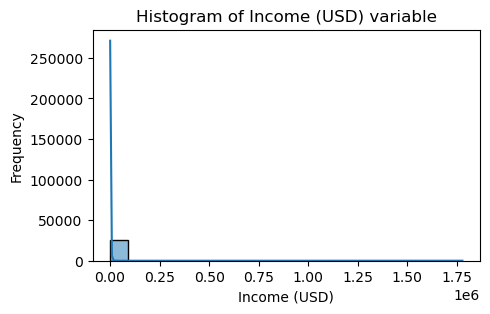

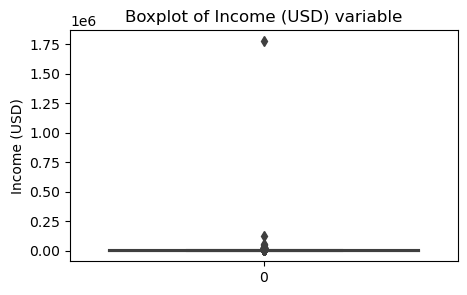

count     29660.000000
mean      88792.057274
std       59480.995253
min        6048.240000
25%       41200.112500
50%       75114.085000
75%      119890.857500
max      621497.820000
Name: Loan Amount Request (USD), dtype: float64


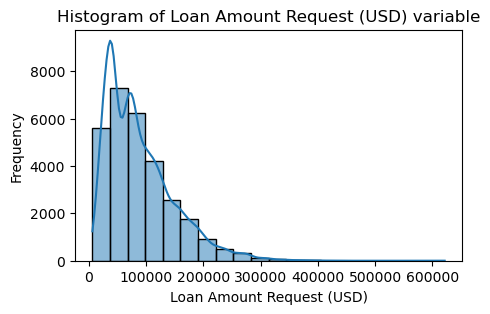

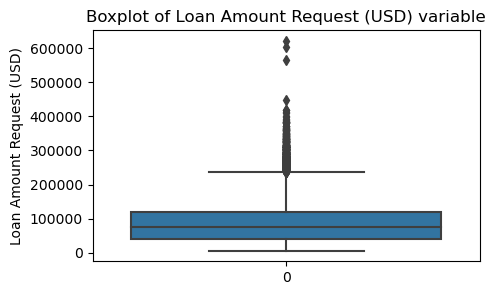

count    29493.000000
mean       400.893752
std        242.265401
min       -999.000000
25%        247.780000
50%        375.090000
75%        521.050000
max       3840.880000
Name: Current Loan Expenses (USD), dtype: float64


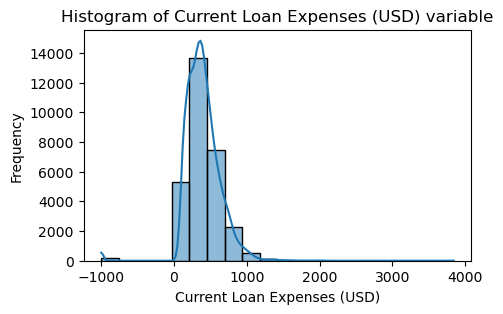

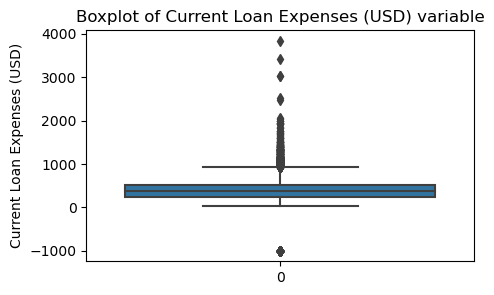

count    27990.000000
mean       739.853475
std         72.152128
min        580.000000
25%        681.732500
50%        739.815000
75%        799.040000
max        896.260000
Name: Credit Score, dtype: float64


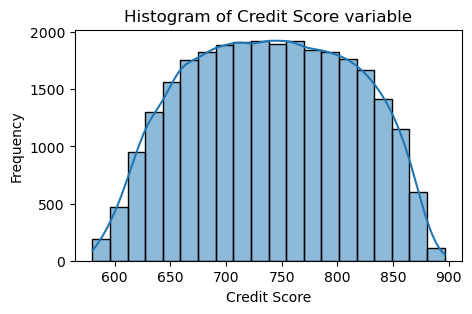

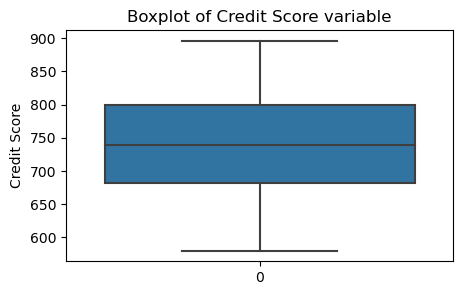

count    2.966000e+04
mean     1.317335e+05
std      9.342129e+04
min     -9.990000e+02
25%      6.065874e+04
50%      1.099936e+05
75%      1.788019e+05
max      1.077967e+06
Name: Property Price, dtype: float64


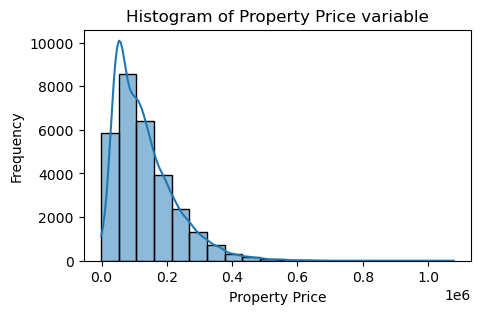

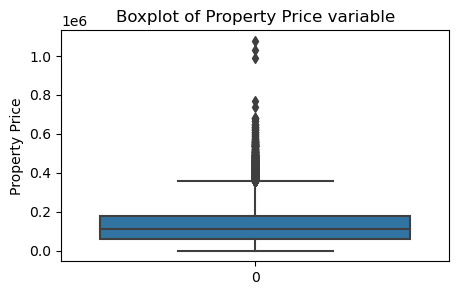

count    2.490000e+04
mean     2.631317e+03
std      1.137831e+04
min      3.777000e+02
25%      1.649810e+03
50%      2.223965e+03
75%      3.090832e+03
max      1.777460e+06
Name: Property Age, dtype: float64


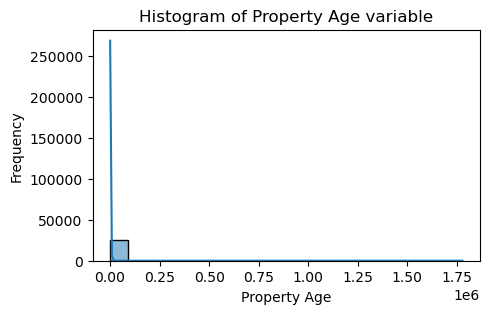

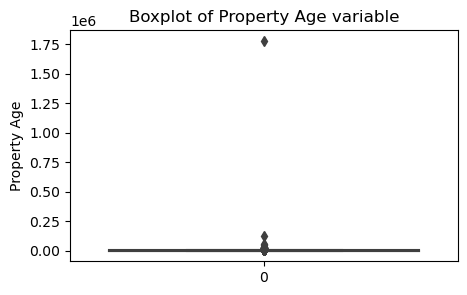

count     29660.000000
mean      47649.342208
std       48221.146686
min        -999.000000
25%           0.000000
50%       35209.395000
75%       74261.250000
max      481907.320000
Name: Loan Sanction Amount (USD), dtype: float64


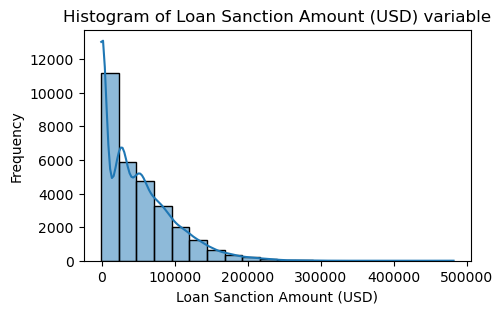

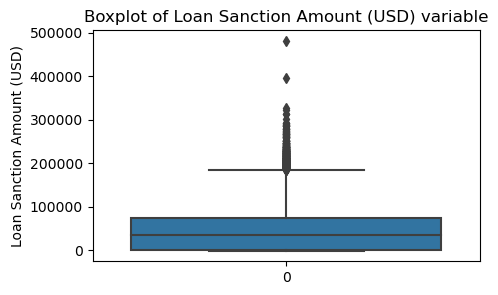

In [55]:
for var in continous_vars:
    # summary statistics 
    print(df2[var].describe())
    
    #histogram
    plt.figure(figsize=(5,3))
    sns.histplot(df2[var], kde=True, bins=20)
    plt.title(f'Histogram of {var} variable')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()
    
    # boxplot
    plt.figure(figsize=(5,3))
    sns.boxplot(df2[var])
    plt.title(f'Boxplot of {var} variable')
    plt.ylabel(var)
    plt.show()

Continous data interpretation from summary statistics, distribution plot and boxplot. 
- Age: Most loan applicants are in the 18-early 20. 
- Income (USD): Distribution is skewed to the right, outlier detected. 
- Loan Amount Request (USD): 75% loan application requested a loan amount less than or equal 119890 (USD). 
- Current Loan Expenses (USD): Inappropriate data entry (-999).
- Credit Score: Normal distribution. 
- Property price: Inappropriate data entry (-999). 
- Property Age: Distribution are skewed to the right. Majority property are new, outlier detected. 
- Loan Sanction Amount (USD):  Distribution are skewed to the right. Inappropriate data detected (-999)


In [ ]:
# checking for the amount of inappriopate data (-999)
subset_inapp = ['Current Loan Expenses (USD)', 'Property Price', 'Loan Sanction Amount (USD)']
data_inapp = (df2[subset_inapp] == -999).sum()
data_inapp

### Univariate Analysis - Categorical Variable

Gender
M    14890
F    14718
Name: count, dtype: int64


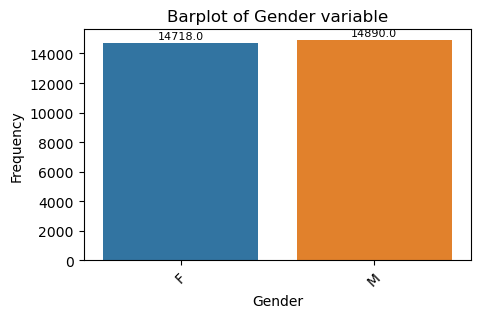

Income Stability
Low     25458
High     2544
Name: count, dtype: int64


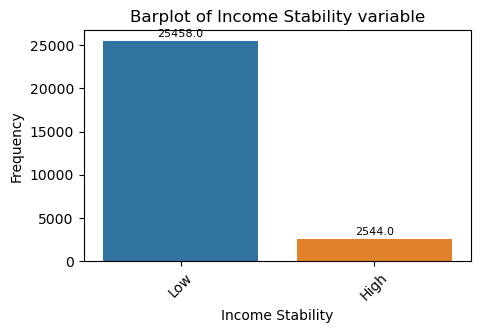

Profession
Working                 16739
Commercial associate     7863
Pensioner                2718
State servant            2334
Unemployed                  2
Businessman                 2
Student                     1
Maternity leave             1
Name: count, dtype: int64


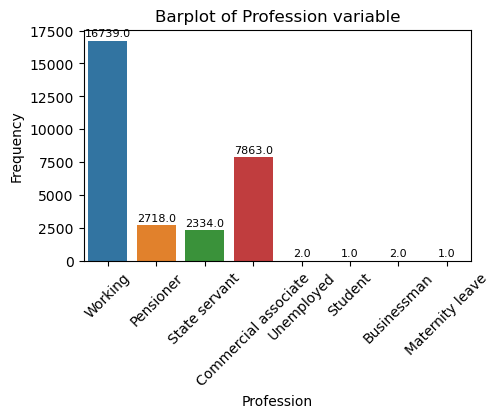

Location
Semi-Urban    21317
Rural          5280
Urban          3063
Name: count, dtype: int64


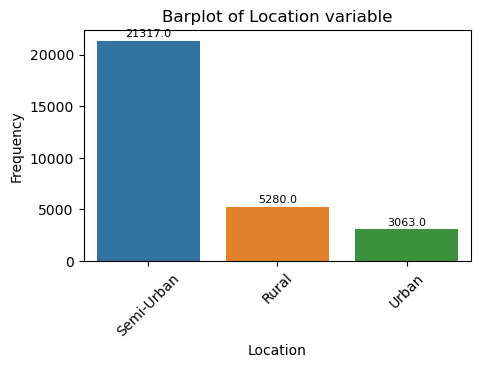

Expense Type 1
N    18984
Y    10676
Name: count, dtype: int64


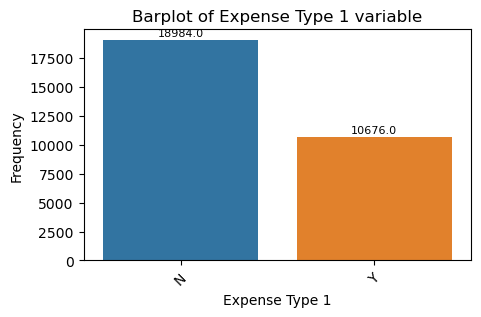

Expense Type 2
Y    19949
N     9711
Name: count, dtype: int64


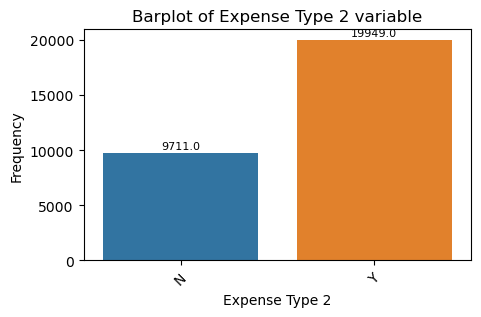

Dependents
2.0     12963
3.0      5653
1.0      5488
4.0      2680
5.0       370
6.0        50
7.0         7
8.0         1
10.0        1
14.0        1
Name: count, dtype: int64


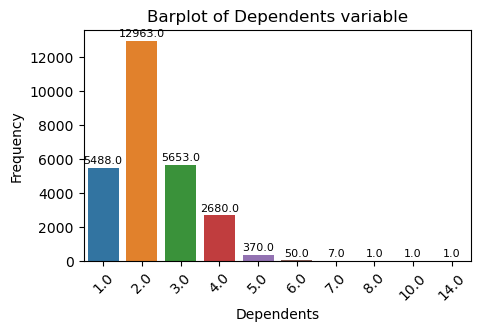

No. of Defaults
0    23904
1     5756
Name: count, dtype: int64


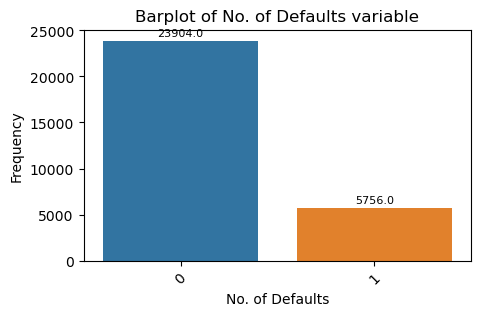

Has Active Credit Card
Active         9668
Inactive       9360
Unpossessed    9086
Name: count, dtype: int64


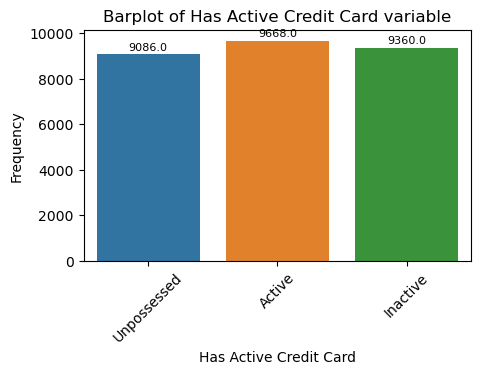

Property Type
1    7777
2    7560
3    7225
4    7098
Name: count, dtype: int64


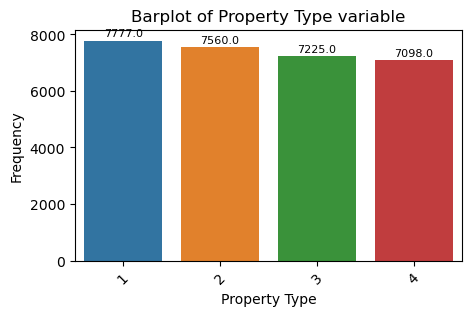

Property Location
Semi-Urban    10255
Rural          9929
Urban          9129
Name: count, dtype: int64


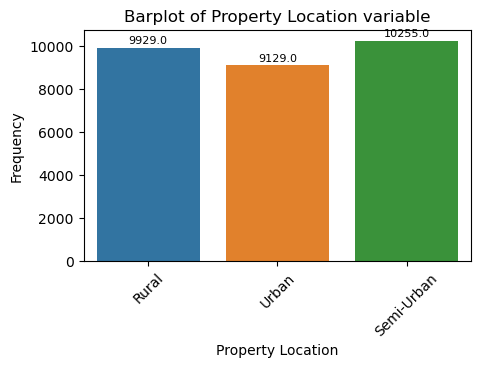

Co-Applicant
 1      25202
 0       4293
-999      165
Name: count, dtype: int64


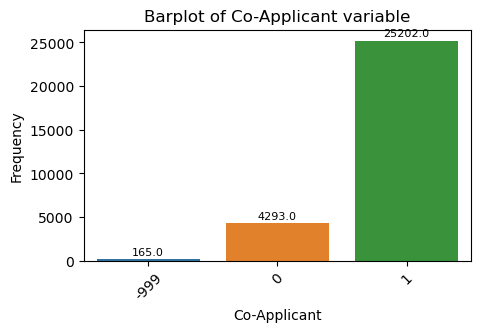

In [7]:
# EDA for categorical variables
for var in categorical_vars:
    print(df2[var].value_counts())

    df2.loc[:, var] = df2[var].astype('category')

    #barplot
    plt.figure(figsize=(5,3))
    sns.countplot(data=df2, x=var)
    plt.title(f'Barplot of {var} variable')
    plt.ylabel('Frequency')
    plt.xlabel(var)
    plt.xticks(rotation=45)
    
    # annote the count values on the bars
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha ='center', va='center', fontsize=8, color='black', xytext=(0,5),
                           textcoords='offset points')
    plt.show()

Categorical data interpretation from summary statistics and bar plot. 
- Gender: Gender distribution is nearly equal between male and female categories. 
- Income Stability: Most applicant (90.9%) have low income stability. 
- Profession: A majority of the applicants are working. (businessman (2), unemployed (2), maternity leave (1), student(1) are to be removed before encoding due to its uncommon profession in dataset.)
- Location: A majority of the applicant location are in semi-rural area. 
- Expense Type I: There are more N type expense than Y.
- Expense Type II: There are more Y type expense than N. 
- Dependents: Most applicants have dependents, a majority are two. 
- Default: Most applicants have 0 defaults. 5756 have defaults. 
- Active Credit Card: Equal distribution of active, inactive, unpossessed. 
- Property Type: Equal distribution of 1,2,3,4 property type
- Property Location: The most popular location is semi-rural, followed by rural, and then urban. 
- Co-applicant: A majority applicants have one co-applicants. Inappropriate data detected (-999).

### Bivariate Analysis - Correlation Plot

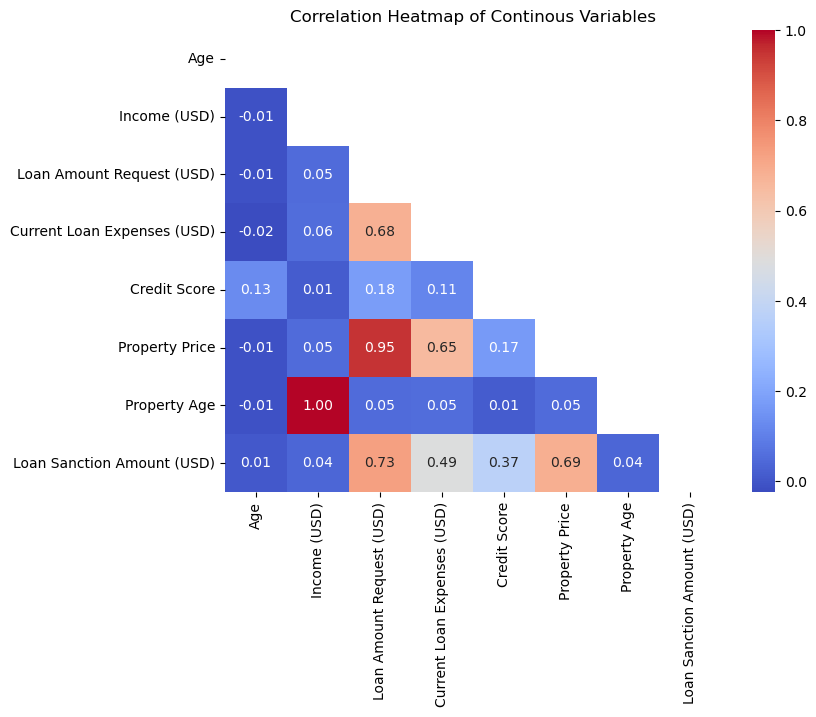

In [8]:
# correlation matrix 
correlation_matrix = df2[continous_vars].corr()
mask = np.triu(np.ones_like(correlation_matrix,dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt ='.2f', mask=mask)
plt.title('Correlation Heatmap of Continous Variables')
plt.show()

Bivariate Analysis - Correlation Heat Map
- Property Age and Income (USD) exhibit a strong positive correlation of 1.0, suggesting a perfect linear relationship between the two variables. This indicates the presence of multicollinearity. 
- Property Price and Current Loan Expenses (USD) also shows high correlation of 0.95. 

### Bivariate Anlaysis - Categorical (Box Plot against Target Variable)

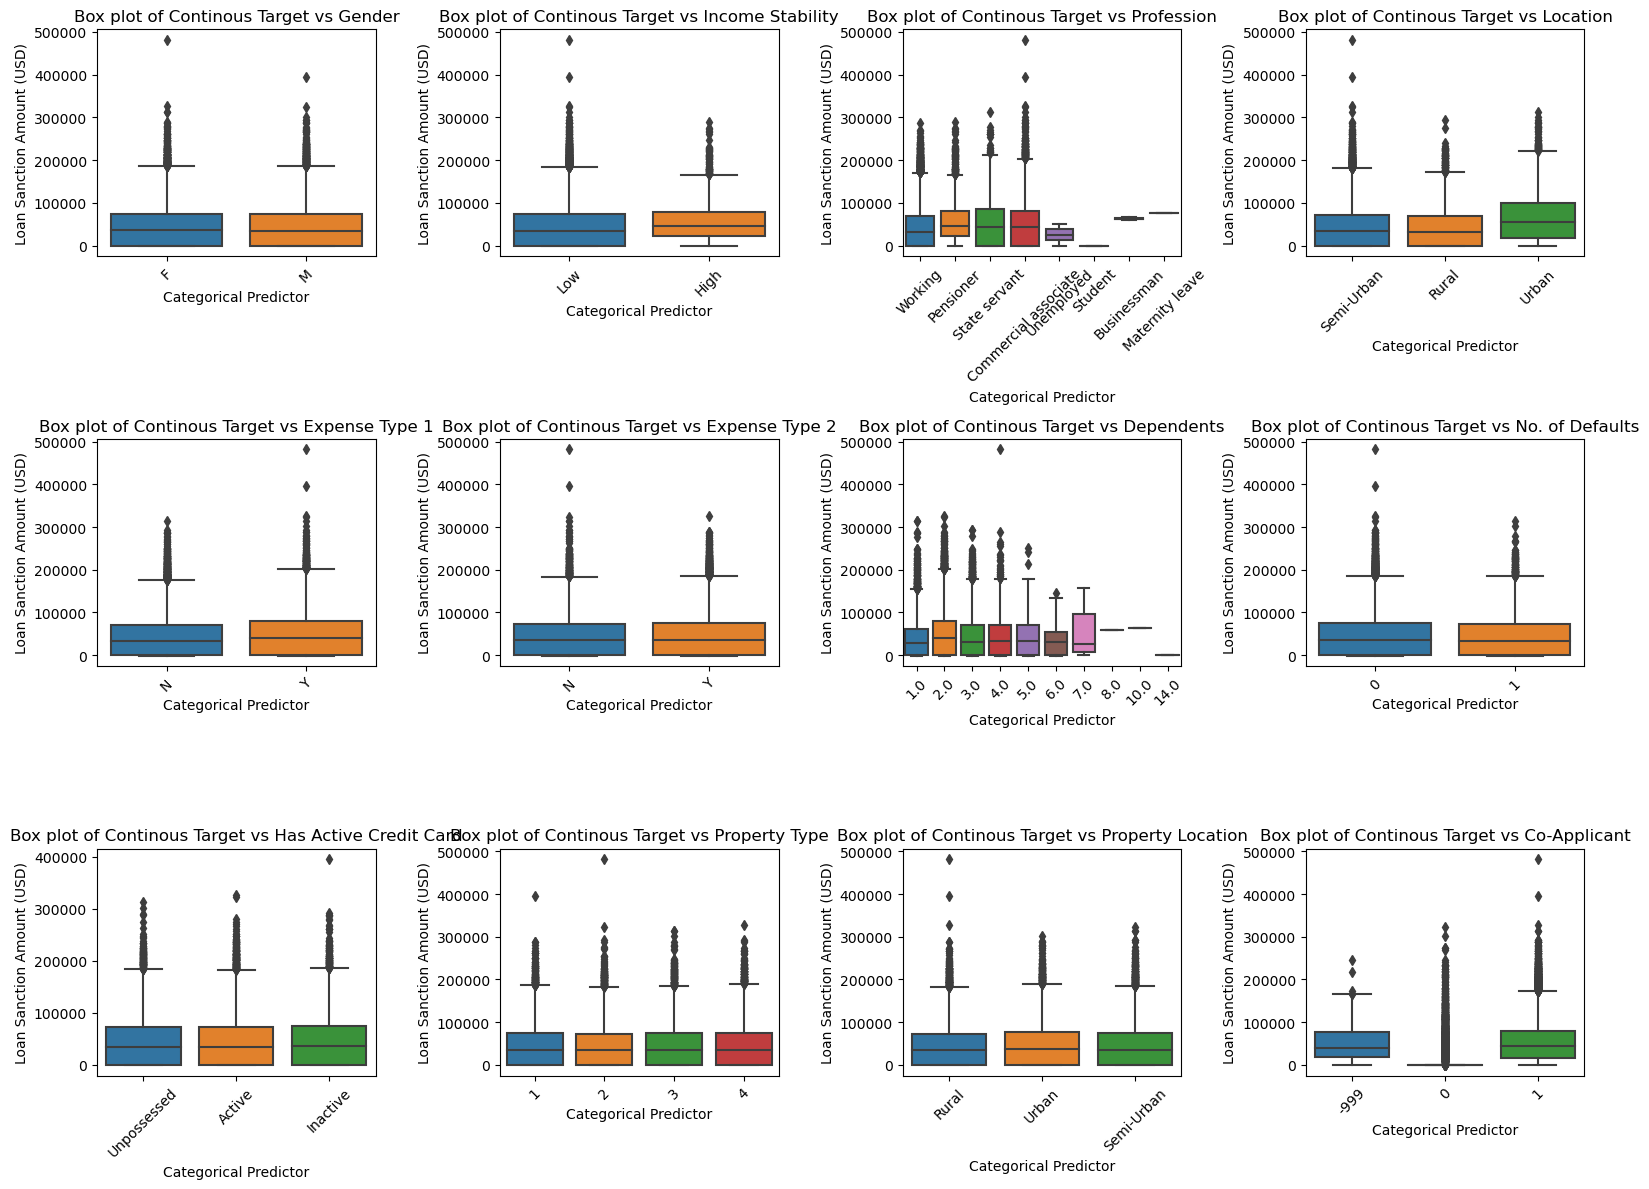

In [9]:
concatenated_data = [] 

plt.figure(figsize=(16, 12))

# loop for categorical 
for i, category in enumerate(categorical_vars,1):
    plt.subplot(3,4,i)
    category_data = []
    
    # looping unique within that category
    for category_value in df2[category].unique():
        subset_data = df2[df2[category] == category_value]
        category_data.append(subset_data)
    
    concatenated_category_data = pd.concat(category_data)
    concatenated_data.append(concatenated_category_data)
    
    # Create a box plot
    sns.boxplot(x=category, y = 'Loan Sanction Amount (USD)', data=concatenated_category_data)
    plt.title(f'Box plot of Continous Target vs {category}')
    plt.xlabel('Categorical Predictor')
    plt.ylabel('Loan Sanction Amount (USD)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Categorical Bivariate Analysis
- Income Stability: Low stability applicants have higher loan sanction amount (USD) compared to applicants with high income stability.

## 3.0 Data Preparation

- Dropping dirty data in target variable. 
- Missing Value Imputer 
- Handling Outliers: Winsorization
- Handling Skewness: Cube root. 
- Multicolinearity: Variance Inflaction Factor. 
- Drop columns with high VIF, and least frequent profession
- One Hot Encoding 
- Scaling Data: MinMax Scaler 
- Splitting Data Target, Train, Test, dataset. 

In [5]:
# drop Loan Sanction Data = -999, since it is target variable. 
class TargetDataCleaner(BaseEstimator, TransformerMixin): 
    def __init__ (self, target_column = 'Loan Sanction Amount (USD)'):
        self.target_column = target_column
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        """
        Drop rows with dirty data in Loan Sanction Amount (USD)
    
        Parameters: 
        - df: DataFrame containing the dataset
    
        Returns:
        - df_cleaned: DataFrame with dirty data removed from the target variable
        """
    
        # Drop rows with dirty data in target variable
        df_cleaned = df[df[self.target_column] != -999].copy()
        return df_cleaned


In [25]:
# replace -999 with 0 
class ValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_999_val=['Co-Applicant', 'Current Loan Expenses (USD)', 'Property Price']):
        self.feat_with_999_val = feat_with_999_val
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_999_val).issubset(df.columns)):
            for ft in self.feat_with_999_val:
                # replace any occurance of -999.000 with 0
                df[ft].replace(-999.000,0,inplace=True,regex=True)
            return df

In [22]:
# Outliers imputer - Winsorization 
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__ (self, vars_with_outliers = ['Income (USD)', 'Loan Amount Request (USD)', 
                                              'Current Loan Expenses (USD)', 'Property Price', 
                                              'Property Age', 'Loan Sanction Amount (USD)']):
        self.vars_with_outliers = vars_with_outliers
        
    def fit(self, df):
        return self
    
    def transform(self, df):
        for feature in self.vars_with_outliers:

            # Calculate quartiles
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define bounds for outliers detection
            lower_bound = Q1 - 1.5*IQR
            upper_bound = Q3 + 1.5*IQR
            
            #winsorization : replace outliers with values at lower and upper bounds
            df[feature] = df[feature].clip(lower_bound, upper_bound)
            
        return df 

In [14]:
# impute missing value with categorical and continous
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__ (self, impute_mode = ['Gender', 'Income Stability', 'Dependents',
                                       'Has Active Credit Card','Property Location'],
                  impute_median = ['Income (USD)', 'Current Loan Expenses (USD)', 
                                   'Credit Score', 'Property Age', 'Property Price']):
        self.impute_mode = impute_mode
        self.impute_median = impute_median
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        if (set(self.impute_mode + self.impute_median).issubset(df.columns)):
            for var in self.impute_mode:
                var_mode = df[var].mode()[0]
                df[var] = df[var].fillna(var_mode)
                    
            for var in self.impute_median:
                var_median = df[var].median()
                df[var] = df[var].fillna(var_median) 
            return df
        

In [9]:
# Handing with cube root element-wise. 
class HandlingSkewness (BaseEstimator, TransformerMixin):
    def __init__ (self, skew_vars= ['Income (USD)', 'Loan Amount Request (USD)',
                                    'Current Loan Expenses (USD)', 'Property Price', 'Property Age']):
        self.skew_vars= skew_vars
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        if set(self.skew_vars).issubset(df.columns):
            df[self.skew_vars] = np.cbrt(df[self.skew_vars])
            return df

In [26]:
def imputed_pipeline(df):
    
    pipeline = Pipeline([
        ('target cleaner', TargetDataCleaner()),
        ('-999 inputer', ValueImputer()),
        ('missing value imputer', MissingValueImputer()),
        ('outlier imputer', OutlierImputer()),
        ('skewness', HandlingSkewness()),
    ])
    imputed_df = pipeline.fit_transform(df) 
    return imputed_df

df3 = imputed_pipeline(df2)
print(df3.shape)
df3.head()  

(29322, 20)


,Gender,Age,Income (USD),Income Stability,Profession,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,F,56,12.457026,Low,Working,Semi-Urban,41.757021,6.223773,N,N,3.0,809.44,0,Active,12.457026,4,Rural,1,49.315123,54607.18
1,M,32,16.585666,Low,Working,Semi-Urban,36.046614,7.914772,N,Y,1.0,780.40,0,Unpossessed,16.520186,2,Rural,1,37.981293,37469.98
2,F,65,9.960477,High,Pensioner,Semi-Urban,35.724502,5.560759,N,Y,1.0,833.15,0,Unpossessed,9.960477,2,Urban,0,41.686360,36474.43
3,F,65,13.050807,High,Pensioner,Rural,43.099090,6.683452,N,Y,2.0,832.70,1,Unpossessed,13.052275,2,Semi-Urban,1,49.520960,56040.54
4,F,31,13.776678,Low,Working,Semi-Urban,48.468061,7.891290,N,Y,2.0,745.55,1,Active,13.776678,4,Semi-Urban,1,59.303796,74008.28


### MultiColinearity

In [27]:
#VIF calculation 
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

continous_vars = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Price', 'Property Age', 'Loan Sanction Amount (USD)']
X_continous = df3[continous_vars]


# Apply VIF contious variable 
def iterative_vif_analysis (df, max_vif = 10):
    while True:
        vif_df = calculate_vif(df)
        max_vif_feature = vif_df.loc[vif_df['VIF'].idxmax()]
        if max_vif_feature ['VIF'] > max_vif:
            df = df.drop(columns=[max_vif_feature['Feature']])
            print(f"Remove variable with High VIF: {max_vif_feature['Feature']} (VIF={max_vif_feature['VIF']})")
        else:
            break
    return data 

data_after_vif = iterative_vif_analysis(X_continous)

Remove variable with High VIF: Property Age (VIF=5332.129395104608)
Remove variable with High VIF: Loan Amount Request (USD) (VIF=142.71823829567663)
Remove variable with High VIF: Income (USD) (VIF=57.77284002233781)
Remove variable with High VIF: Current Loan Expenses (USD) (VIF=47.15308998616894)
Remove variable with High VIF: Credit Score (VIF=22.968251546932915)


In [28]:
# Drop columns with high VIF 
col_multicol = ['Property Age', 'Loan Amount Request (USD)', 'Income (USD)', 'Current Loan Expenses (USD)', 'Credit Score']
df3 = df3.drop(columns=df3[col_multicol])
df3.head()

,Gender,Age,Income Stability,Profession,Location,Expense Type 1,Expense Type 2,Dependents,No. of Defaults,Has Active Credit Card,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,F,56,Low,Working,Semi-Urban,N,N,3.0,0,Active,4,Rural,1,49.315123,54607.18
1,M,32,Low,Working,Semi-Urban,N,Y,1.0,0,Unpossessed,2,Rural,1,37.981293,37469.98
2,F,65,High,Pensioner,Semi-Urban,N,Y,1.0,0,Unpossessed,2,Urban,0,41.686360,36474.43
3,F,65,High,Pensioner,Rural,N,Y,2.0,1,Unpossessed,2,Semi-Urban,1,49.520960,56040.54
4,F,31,Low,Working,Semi-Urban,N,Y,2.0,1,Active,4,Semi-Urban,1,59.303796,74008.28


In [29]:
class DropUncommonProfession(BaseEstimator, TransformerMixin):
    def __init__(self,profession_list = ['Student','Unemployed','Businessman', 'Maternity leave']):
        self.profession_list = profession_list
    def fit(self,df):
        return self
    def transform(self,df):
        if ('Profession' in df.columns):
            # only keep the professions that are not in the profession_list
            df = df[~df['Profession'].isin(self.profession_list)]
            return df
        else:
            print("Profession feature is not in the dataframe")
            return df


In [30]:
# Replace one-hot encoding 
class OneHotEncoding (BaseEstimator, TransformerMixin):
    def __init__ (self, categorical_vars=['Gender', 'Income Stability', 'Profession', 
                                          'Location', 'Expense Type 1', 'Expense Type 2',
                                          'Has Active Credit Card',
                                          'Property Location']):
        self.categorical_vars = categorical_vars
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        for var in self.categorical_vars:
            one_hot_encoded_data = pd.get_dummies(df[var], prefix=var)
            
            boolean_columns = one_hot_encoded_data.select_dtypes(include=['bool']).columns
            one_hot_encoded_data[boolean_columns] = one_hot_encoded_data[boolean_columns].astype(int)

            df = df.drop(columns=[var])
            df = pd.concat([df, one_hot_encoded_data], axis=1)
            
        return df

In [31]:
class MinMax (BaseEstimator, TransformerMixin):
    def __init__(self, continous_vars= ['Age', 'Property Price', 'Loan Sanction Amount (USD)']):
        self.continous_vars = continous_vars
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        if set(self.continous_vars).issubset(df.columns): 
            min_max_enc = MinMaxScaler()
            df[self.continous_vars] = min_max_enc.fit_transform(df[self.continous_vars])
            return df  

In [33]:
def scaled_pipeline(df):
    
    pipeline = Pipeline([
        ('Uncommon Profession', DropUncommonProfession()),
        ('One Hot Encoding for Categorical', OneHotEncoding()),
        ('Scaling with MinMax', MinMax()),
    ])
    imputed_df = pipeline.fit_transform(df) 
    return imputed_df

df4 = scaled_pipeline(df3)
print(df4.shape)
df4.head() 

(29316, 28)


,Age,Dependents,No. of Defaults,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD),Gender_F,Gender_M,Income Stability_High,...,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban
0,0.808511,3.0,0,4,1,0.695699,0.292098,1,0,0,...,1,0,1,0,1,0,0,1,0,0
1,0.297872,1.0,0,2,1,0.535810,0.200430,0,1,0,...,1,0,0,1,0,0,1,1,0,0
2,1.000000,1.0,0,2,0,0.588078,0.195104,1,0,1,...,1,0,0,1,0,0,1,0,0,1
3,1.000000,2.0,1,2,1,0.698602,0.299765,1,0,1,...,1,0,0,1,0,0,1,0,1,0
4,0.276596,2.0,1,4,1,0.836611,0.395876,1,0,0,...,1,0,0,1,1,0,0,0,1,0


In [34]:
df4.columns

Index(['Age', 'Dependents', 'No. of Defaults', 'Property Type', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)', 'Gender_F', 'Gender_M',
       'Income Stability_High', 'Income Stability_Low',
       'Profession_Commercial associate', 'Profession_Pensioner',
       'Profession_State servant', 'Profession_Working', 'Location_Rural',
       'Location_Semi-Urban', 'Location_Urban', 'Expense Type 1_N',
       'Expense Type 1_Y', 'Expense Type 2_N', 'Expense Type 2_Y',
       'Has Active Credit Card_Active', 'Has Active Credit Card_Inactive',
       'Has Active Credit Card_Unpossessed', 'Property Location_Rural',
       'Property Location_Semi-Urban', 'Property Location_Urban'],
      dtype='object')

### Split Data 

In [36]:
X = df4.drop(columns=['Loan Sanction Amount (USD)'])  # Features
y = df4['Loan Sanction Amount (USD)']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
print('X_train.shape:', X_train.shape)
print('X_train.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)
print('y_train.shape:', y_train.shape)



X_train.shape: (23452, 27)
X_train.shape: (5864, 27)
y_test.shape: (5864,)
y_train.shape: (23452,)


## 4.0 Modeling

### 4.1 Linear Models (Linear, Ridge, Lasso)

In [46]:
# Linear Regression 
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_reg.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print("Mean Squared Error:", mse_linear)
print("Root Mean Squared Error:", rmse_linear)
print("r2 score:", r2_linear)

Mean Squared Error: 0.03404241392805159
Root Mean Squared Error: 0.1845058642104678
r2 score: 0.4545682735765474


In [50]:
# Ridges Regression 
ridge_reg = Ridge(alpha=2.0)
ridge_reg.fit(X_train, y_train)

y_pred_ridge = ridge_reg.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression - MSE:", mse_ridge)
print("Ridge Regression - RMSE:", rmse_ridge)
print("Ridge Regression - R2 Score:", r2_ridge)

Ridge Regression - MSE: 0.03404793692579273
Ridge Regression - RMSE: 0.1845208306012975
Ridge Regression - R2 Score: 0.4544797834301273


In [51]:
# Lasso 
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)

y_pred_lasso = lasso_reg.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print('Lasso Regresion - MSE', mse_lasso)
print("Lasso Regression - RMSE:", rmse_lasso)
print("Lasso Regression - R2 Score:", r2_lasso)


Lasso Regresion - MSE 0.062414203972500776
Lasso Regression - RMSE: 0.24982834901688153
Lasso Regression - R2 Score: -8.022287009579188e-06


### 4.2 Ensemble Learning Models (Random Forest, XGBoost)

In [52]:
# Convert data to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set hyperparameters
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

# Train the model
xgb_model = xgb.train(params, dtrain)

# Make predictions
y_pred_xgb = xgb_model.predict(dtest)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb= np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost - MSE:", mse_xgb)
print("XGBoost - RMSE:", rmse_xgb)
print("XGBoost - R2 Score:", r2_xgb)

XGBoost - MSE: 0.023711392280250904
XGBoost - RMSE: 0.15398503914423278
XGBoost - R2 Score: 0.6200931680504599


In [53]:
# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest MSE:", mse_rf)
print("Random Forest - RMSE:", rmse_rf)
print("Random Fores- R2 Score:", r2_rf)

Random Forest MSE: 0.024785394176510503
Random Forest - RMSE: 0.15743377711441248
Random Fores- R2 Score: 0.6028853780947591
